## 1. Сгенерировать пакетом hopfield-tracking датасет spdsim с параметрами по умолчанию

In [ ]:
import vispy
# selecting sub-backend behind jupyter_rfb:
# 1) pyglfw has high priority if present
# 2) to use any other backend, install then designate as default
# 4) use jupyter_rfb, it then selects the sub-backend according to config
# 5) enable jupyterlab extensions for interactive widget provided by jupyter_rfb

# only needed in jhub2, jhub and jlab-hpc can't run opengl at all, locally auto-selected backend is OK
vispy.config.update(default_backend='egl')
vispy.use('jupyter_rfb')

RFBOutputContext()

RFBOutputContext()

CanvasBackend(css_height='768px', css_width='1024px')
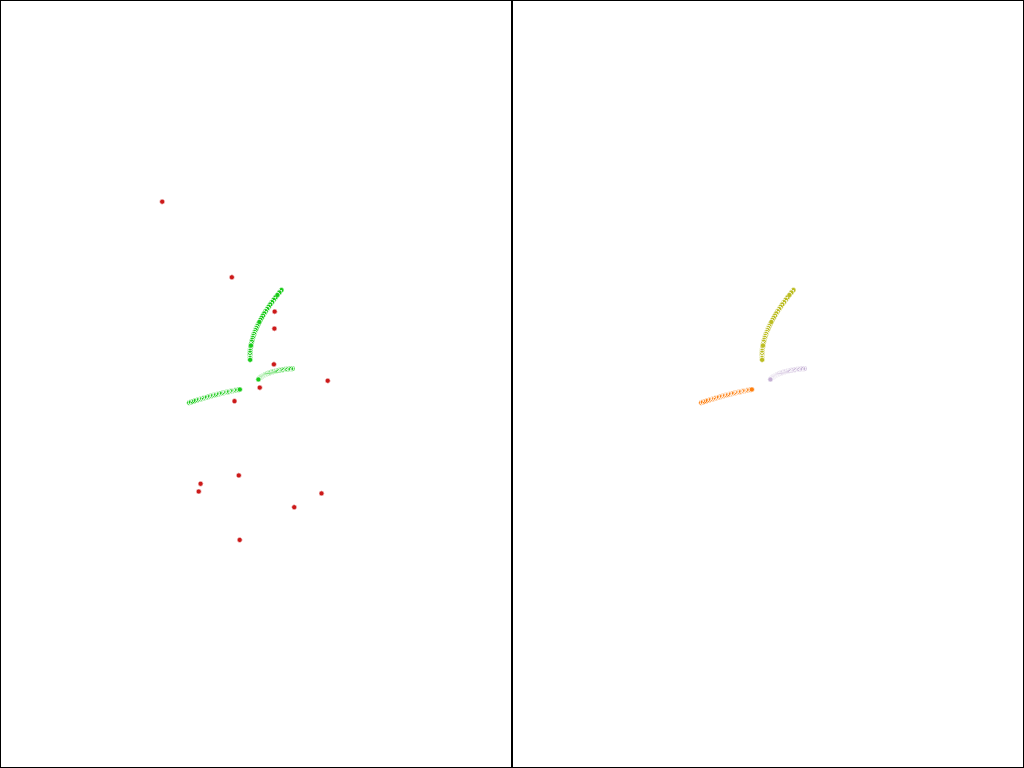

In [ ]:
from segment.candidate import gen_seg_layered
from segment.track import gen_seg_track_layered, gen_seg_track_sequential
from tracking.plot import plot_event, plot_seg_diff
from vispy.scene import SceneCanvas
from datasets import get_hits

canvas = SceneCanvas(bgcolor='white', size=(1000, 1500))
grid = canvas.central_widget.add_grid()

event = get_hits('spdsim', 1)
plot_event(event)

In [ ]:
event

,x,y,z,layer,track,event_id
0,193.815497,-187.972238,-104.745437,1,0,0
1,200.285952,-205.638740,-109.063967,2,0,0
2,205.648295,-224.051984,-113.267063,3,0,0
3,210.210628,-242.829841,-117.454628,4,0,0
4,213.693258,-262.221678,-121.642656,5,0,0
...,...,...,...,...,...,...
256,-66.901813,470.009137,-2266.595653,12,-1,0
257,235.346500,-132.306791,-1241.773186,0,-1,0
258,-238.309352,-370.581610,-1885.612386,10,-1,0
259,-288.969912,439.258185,-2208.802405,15,-1,0


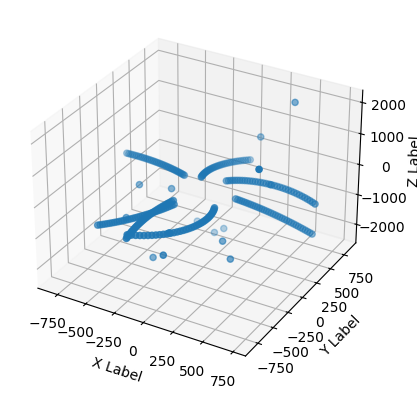

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def draw_event(df):
    # Создание фигуры и осей
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Генерация данных
    x = df['x']
    y = df['y']
    z = df['z']

    # Построение графика
    ax.scatter(x, y, z)

    # Настройка осей
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')

    # Отображение графика
    plt.show()

draw_event(event)

## 2. Добавить цилиндрические координаты хитов вокруг оси z

In [ ]:
from tracking.hit import add_cylindric_coordinates

add_cylindric_coordinates(event)

,x,y,z,layer,track,event_id,r,phi
0,193.815497,-187.972238,-104.745437,1,0,0,269.996313,-0.770094
1,200.285952,-205.638740,-109.063967,2,0,0,287.057057,-0.798584
2,205.648295,-224.051984,-113.267063,3,0,0,304.122530,-0.828201
3,210.210628,-242.829841,-117.454628,4,0,0,321.177272,-0.857275
4,213.693258,-262.221678,-121.642656,5,0,0,338.267670,-0.887016
...,...,...,...,...,...,...,...,...
256,-66.901813,470.009137,-2266.595653,12,-1,0,474.746713,1.712188
257,235.346500,-132.306791,-1241.773186,0,-1,0,269.987151,-0.512145
258,-238.309352,-370.581610,-1885.612386,10,-1,0,440.592870,-2.142283
259,-288.969912,439.258185,-2208.802405,15,-1,0,525.786423,2.152676


## 3. Реализовать с помощью любого метода машинного обучения классификацию хитов на настоящие и шумовые. Визуализировать результат для одного тестового события. Посчитать f1_score классификации на тестовом датасете spdsim с параметрами по умолчанию.

Для того чтобы получить f1_score классификации добавим в dataframe event столбец color.
В него будут записываться значения 0 (точки красного цвета т.е. шумы) и 1 (точки зеленого цвета).
Для этого в файл hopfield-tracking/tracking/plot.py добавим функцию color_to_event.
"""
    def color_to_event(event, color):
    color_list = []
    for row in color:
    	if (row == [.8, .1, .1]).all():
        	color_list.append(0)
    	else:
        	color_list.append(1)

    event['color'] = color_list
"""

Вызывать функцию будем в функции plot_event сразу после получения цветов точек.

"""
    def plot_event(event: pd.DataFrame, seg: np.ndarray = None, kdims: Iterable = ('x', 'y', 'z'),
               fig_size: Tuple[int, int] = (1024, 768)) -> SceneCanvas:
    kdims = list(kdims)
    canvas = SceneCanvas(bgcolor='white', size=fig_size)
    grid = canvas.central_widget.add_grid()

    color = np.where((event.track.to_numpy() == -1)[..., np.newaxis], [.8, .1, .1], [.1, .8, .1])

	color_to_event(event, color)

    fakes_view = _hits_view(event, kdims, color)
    grid.add_widget(fakes_view)

    cmap = colormap.MatplotlibColormap('tab20')
    event = event[event.track != -1]
    track_enum = {t: np.random.rand() for t in event.track.unique()}
    color = cmap.map(event.track.map(track_enum))
    track_view = _hits_view(event, kdims, color, fakes_view.camera)
    grid.add_widget(track_view)

    if seg is not None:
        seg_view = _seg_view(event, seg, kdims, camera=fakes_view.camera)
        grid.add_widget(seg_view)
    return canvas

"""

RFBOutputContext()

RFBOutputContext()

CanvasBackend(css_height='768px', css_width='1024px')
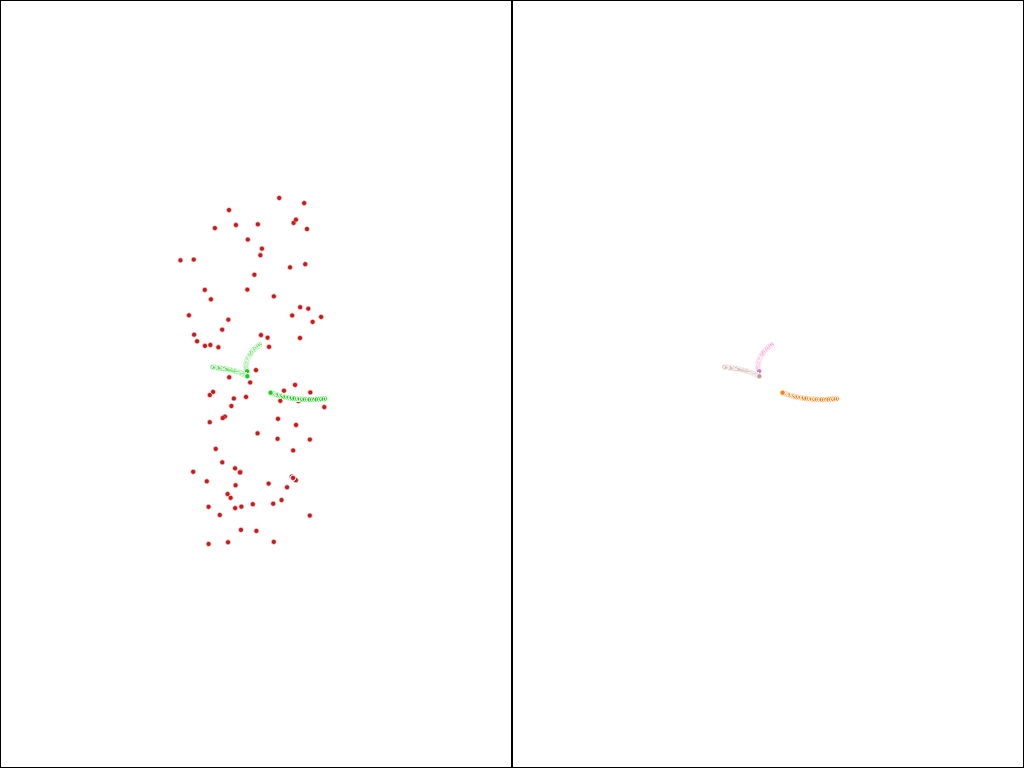

In [ ]:
from tracking.hit import add_cylindric_coordinates

canvas = SceneCanvas(bgcolor='white', size=(1000, 1500))
grid = canvas.central_widget.add_grid()

event = get_hits('spdsim', 1)
add_cylindric_coordinates(event)
plot_event(event)

In [ ]:
event

,x,y,z,layer,track,event_id,r,phi,color
0,-210.021226,169.649519,-21.073628,1,0,0,269.981249,2.462130,1
1,-224.904562,178.353427,-24.188597,2,0,0,287.040078,2.471123,1
2,-240.024274,186.753421,-27.249348,3,0,0,304.119207,2.480373,1
3,-255.302594,194.906693,-30.514439,4,0,0,321.197811,2.489549,1
4,-270.684299,202.849277,-33.747584,5,0,0,338.257031,2.498479,1
...,...,...,...,...,...,...,...,...,...
189,368.426734,299.393036,-39.161230,12,-1,0,474.736188,0.682392,0
190,-535.841074,-162.989816,-209.123164,17,-1,0,560.081544,-2.846309,0
191,316.417033,119.896162,-42.505708,4,-1,0,338.370844,0.362201,0
192,346.730906,-77.436207,-592.893011,5,-1,0,355.272695,-0.219727,0


In [ ]:
event.to_csv('hits_filter.csv', index=False)

In [40]:
import pandas as pd

df = pd.read_csv('hits_filter.csv')
df

,x,y,z,layer,track,event_id,r,phi,color
0,-210.021226,169.649519,-21.073628,1,0,0,269.981249,2.462130,1
1,-224.904562,178.353427,-24.188597,2,0,0,287.040078,2.471123,1
2,-240.024274,186.753421,-27.249348,3,0,0,304.119207,2.480373,1
3,-255.302594,194.906693,-30.514439,4,0,0,321.197811,2.489549,1
4,-270.684299,202.849277,-33.747584,5,0,0,338.257031,2.498479,1
...,...,...,...,...,...,...,...,...,...
189,368.426734,299.393036,-39.161230,12,-1,0,474.736188,0.682392,0
190,-535.841074,-162.989816,-209.123164,17,-1,0,560.081544,-2.846309,0
191,316.417033,119.896162,-42.505708,4,-1,0,338.370844,0.362201,0
192,346.730906,-77.436207,-592.893011,5,-1,0,355.272695,-0.219727,0


In [41]:
event = df.drop('color', axis=1)
event

,x,y,z,layer,track,event_id,r,phi
0,-210.021226,169.649519,-21.073628,1,0,0,269.981249,2.462130
1,-224.904562,178.353427,-24.188597,2,0,0,287.040078,2.471123
2,-240.024274,186.753421,-27.249348,3,0,0,304.119207,2.480373
3,-255.302594,194.906693,-30.514439,4,0,0,321.197811,2.489549
4,-270.684299,202.849277,-33.747584,5,0,0,338.257031,2.498479
...,...,...,...,...,...,...,...,...
189,368.426734,299.393036,-39.161230,12,-1,0,474.736188,0.682392
190,-535.841074,-162.989816,-209.123164,17,-1,0,560.081544,-2.846309
191,316.417033,119.896162,-42.505708,4,-1,0,338.370844,0.362201
192,346.730906,-77.436207,-592.893011,5,-1,0,355.272695,-0.219727


### Генерация тестового датасета

RFBOutputContext()

RFBOutputContext()

CanvasBackend(css_height='768px', css_width='1024px')
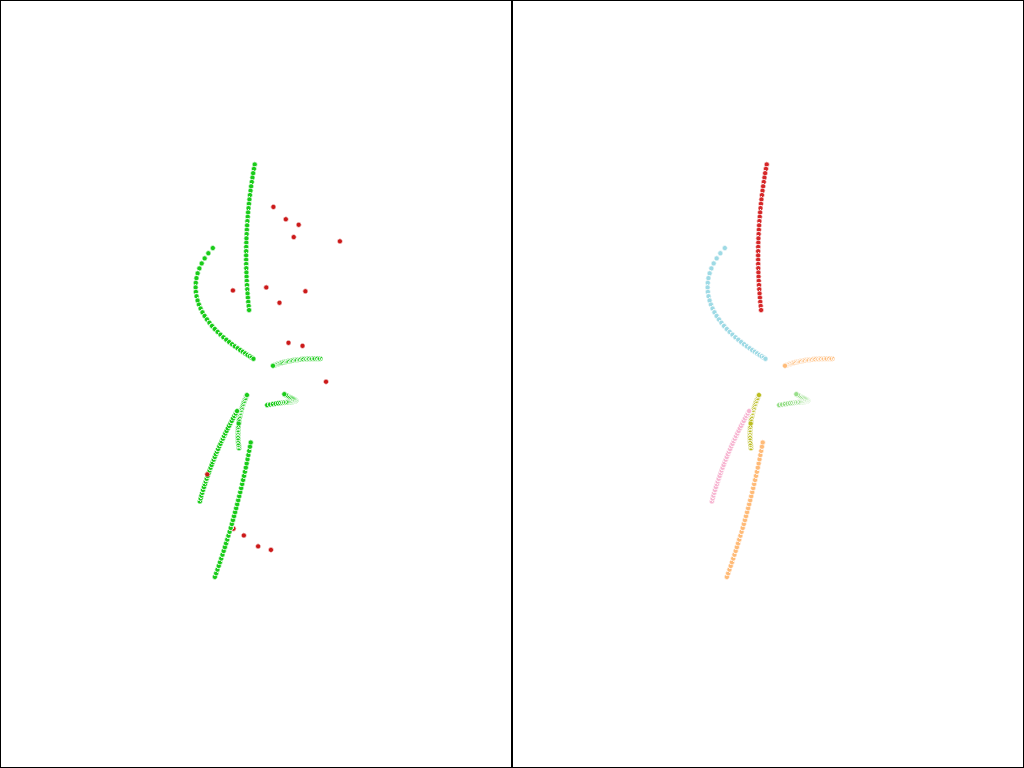

In [55]:
from segment.candidate import gen_seg_layered
from segment.track import gen_seg_track_layered, gen_seg_track_sequential
from tracking.plot import plot_event, plot_seg_diff
from vispy.scene import SceneCanvas
from tracking.hit import add_cylindric_coordinates
from datasets import get_hits

canvas = SceneCanvas(bgcolor='white', size=(1000, 1500))
grid = canvas.central_widget.add_grid()

event_test = get_hits('spdsim', 1)
add_cylindric_coordinates(event_test)
plot_event(event_test)

In [52]:
event_test

,x,y,z,layer,track,event_id,color
0,-119.892766,241.980330,281.242868,1,0,0,1
1,-130.632646,255.517768,294.519110,2,0,0,1
2,-141.582910,269.100399,307.524236,3,0,0,1
3,-152.908997,282.387005,320.684898,4,0,0,1
4,-164.551590,295.476749,334.103968,5,0,0,1
...,...,...,...,...,...,...,...
93,661.498338,32.374609,-1464.352225,23,-1,0,0
94,-191.708601,-213.633955,-1543.536663,1,-1,0,0
95,775.187964,101.164606,-1751.728339,30,-1,0,0
96,489.589226,-46.506221,923.886411,13,-1,0,0


### Классификация RandomForestClassifier

In [74]:
import pandas as pd

df = pd.read_csv('hits_filter.csv')
df

,x,y,z,layer,track,event_id,r,phi,color
0,-210.021226,169.649519,-21.073628,1,0,0,269.981249,2.462130,1
1,-224.904562,178.353427,-24.188597,2,0,0,287.040078,2.471123,1
2,-240.024274,186.753421,-27.249348,3,0,0,304.119207,2.480373,1
3,-255.302594,194.906693,-30.514439,4,0,0,321.197811,2.489549,1
4,-270.684299,202.849277,-33.747584,5,0,0,338.257031,2.498479,1
...,...,...,...,...,...,...,...,...,...
189,368.426734,299.393036,-39.161230,12,-1,0,474.736188,0.682392,0
190,-535.841074,-162.989816,-209.123164,17,-1,0,560.081544,-2.846309,0
191,316.417033,119.896162,-42.505708,4,-1,0,338.370844,0.362201,0
192,346.730906,-77.436207,-592.893011,5,-1,0,355.272695,-0.219727,0


In [76]:
y_train = df['color'].to_numpy()
y_train

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [84]:
df_train = df.drop('color', axis=1)
df_train

,x,y,z,layer,track,event_id,r,phi
0,-210.021226,169.649519,-21.073628,1,0,0,269.981249,2.462130
1,-224.904562,178.353427,-24.188597,2,0,0,287.040078,2.471123
2,-240.024274,186.753421,-27.249348,3,0,0,304.119207,2.480373
3,-255.302594,194.906693,-30.514439,4,0,0,321.197811,2.489549
4,-270.684299,202.849277,-33.747584,5,0,0,338.257031,2.498479
...,...,...,...,...,...,...,...,...
189,368.426734,299.393036,-39.161230,12,-1,0,474.736188,0.682392
190,-535.841074,-162.989816,-209.123164,17,-1,0,560.081544,-2.846309
191,316.417033,119.896162,-42.505708,4,-1,0,338.370844,0.362201
192,346.730906,-77.436207,-592.893011,5,-1,0,355.272695,-0.219727


In [85]:
x_train = df_train.to_numpy()
x_train

array([[-2.10021226e+02,  1.69649519e+02, -2.10736282e+01, ...,
         0.00000000e+00,  2.69981249e+02,  2.46212989e+00],
       [-2.24904562e+02,  1.78353427e+02, -2.41885973e+01, ...,
         0.00000000e+00,  2.87040078e+02,  2.47112339e+00],
       [-2.40024274e+02,  1.86753421e+02, -2.72493483e+01, ...,
         0.00000000e+00,  3.04119207e+02,  2.48037331e+00],
       ...,
       [ 3.16417033e+02,  1.19896162e+02, -4.25057079e+01, ...,
         0.00000000e+00,  3.38370844e+02,  3.62201342e-01],
       [ 3.46730906e+02, -7.74362068e+01, -5.92893011e+02, ...,
         0.00000000e+00,  3.55272695e+02, -2.19726525e-01],
       [ 2.70994845e+02, -3.47375651e+02,  8.80826560e+02, ...,
         0.00000000e+00,  4.40576950e+02, -9.08295156e-01]])

In [132]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=90)

clf.fit(x_train, y_train)

RandomForestClassifier(n_estimators=90)

### Визуализация

In [139]:
df_test

,x,y,z,layer,track,event_id,r,phi
0,-179.307354,-201.882343,-158.584233,1,0,0,270.014088,-2.297041
1,-188.551958,-216.468847,-185.529744,2,0,0,287.072469,-2.287376
2,-197.574846,-231.197473,-212.575524,3,0,0,304.118548,-2.277939
3,-206.175833,-246.296304,-239.230637,4,0,0,321.201406,-2.267756
4,-214.690812,-261.359492,-266.382923,5,0,0,338.232063,-2.258474
...,...,...,...,...,...,...,...,...
257,56.159360,316.259353,1008.239809,3,-1,0,321.206869,1.395054
258,-4.483719,542.858739,1868.706024,16,-1,0,542.877255,1.579056
259,727.740892,329.437472,1836.895177,31,-1,0,798.834059,0.425085
260,3.808034,-611.058456,-1455.286889,20,-1,0,611.070322,-1.564565


In [140]:
cluster = pd.DataFrame(y_test, columns=['cluster'])
df_test = pd.concat([df_test, cluster], axis=1)
df_test

,x,y,z,layer,track,event_id,r,phi,cluster
0,-179.307354,-201.882343,-158.584233,1,0,0,270.014088,-2.297041,0
1,-188.551958,-216.468847,-185.529744,2,0,0,287.072469,-2.287376,0
2,-197.574846,-231.197473,-212.575524,3,0,0,304.118548,-2.277939,0
3,-206.175833,-246.296304,-239.230637,4,0,0,321.201406,-2.267756,0
4,-214.690812,-261.359492,-266.382923,5,0,0,338.232063,-2.258474,0
...,...,...,...,...,...,...,...,...,...
257,56.159360,316.259353,1008.239809,3,-1,0,321.206869,1.395054,0
258,-4.483719,542.858739,1868.706024,16,-1,0,542.877255,1.579056,0
259,727.740892,329.437472,1836.895177,31,-1,0,798.834059,0.425085,0
260,3.808034,-611.058456,-1455.286889,20,-1,0,611.070322,-1.564565,0


In [141]:
df0 = df_test.loc[df_test['cluster'] == 0]
df1 = df_test.loc[df_test['cluster'] == 1]

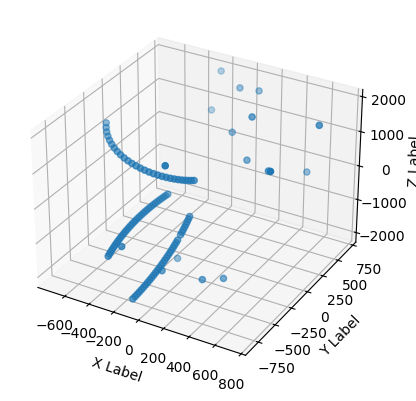

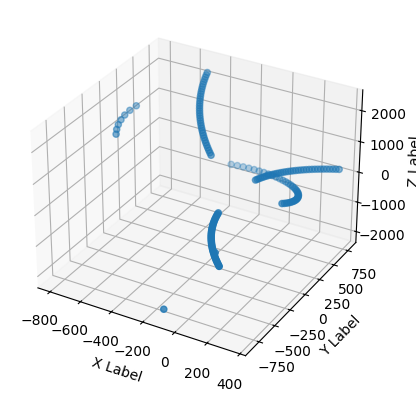

In [142]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


def draw_event(df):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')


    x = df['x']
    y = df['y']
    z = df['z']


    ax.scatter(x, y, z)


    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')


    plt.show()

draw_event(df0)
draw_event(df1)

### Подсчет f1_score

In [133]:
event_test

,x,y,z,layer,track,event_id,r,phi,color
0,-179.307354,-201.882343,-158.584233,1,0,0,270.014088,-2.297041,1
1,-188.551958,-216.468847,-185.529744,2,0,0,287.072469,-2.287376,1
2,-197.574846,-231.197473,-212.575524,3,0,0,304.118548,-2.277939,1
3,-206.175833,-246.296304,-239.230637,4,0,0,321.201406,-2.267756,1
4,-214.690812,-261.359492,-266.382923,5,0,0,338.232063,-2.258474,1
...,...,...,...,...,...,...,...,...,...
257,56.159360,316.259353,1008.239809,3,-1,0,321.206869,1.395054,0
258,-4.483719,542.858739,1868.706024,16,-1,0,542.877255,1.579056,0
259,727.740892,329.437472,1836.895177,31,-1,0,798.834059,0.425085,0
260,3.808034,-611.058456,-1455.286889,20,-1,0,611.070322,-1.564565,0


In [134]:
y_test_right = event_test['color'].to_numpy()
y_test_right

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=int64)

In [135]:
df_test = event_test.drop('color', axis=1)
df_test

,x,y,z,layer,track,event_id,r,phi
0,-179.307354,-201.882343,-158.584233,1,0,0,270.014088,-2.297041
1,-188.551958,-216.468847,-185.529744,2,0,0,287.072469,-2.287376
2,-197.574846,-231.197473,-212.575524,3,0,0,304.118548,-2.277939
3,-206.175833,-246.296304,-239.230637,4,0,0,321.201406,-2.267756
4,-214.690812,-261.359492,-266.382923,5,0,0,338.232063,-2.258474
...,...,...,...,...,...,...,...,...
257,56.159360,316.259353,1008.239809,3,-1,0,321.206869,1.395054
258,-4.483719,542.858739,1868.706024,16,-1,0,542.877255,1.579056
259,727.740892,329.437472,1836.895177,31,-1,0,798.834059,0.425085
260,3.808034,-611.058456,-1455.286889,20,-1,0,611.070322,-1.564565


In [136]:
x_test = df_test.to_numpy()
x_test

array([[-1.79307354e+02, -2.01882343e+02, -1.58584233e+02, ...,
         0.00000000e+00,  2.70014088e+02, -2.29704113e+00],
       [-1.88551958e+02, -2.16468847e+02, -1.85529744e+02, ...,
         0.00000000e+00,  2.87072469e+02, -2.28737629e+00],
       [-1.97574846e+02, -2.31197473e+02, -2.12575524e+02, ...,
         0.00000000e+00,  3.04118548e+02, -2.27793859e+00],
       ...,
       [ 7.27740892e+02,  3.29437472e+02,  1.83689518e+03, ...,
         0.00000000e+00,  7.98834059e+02,  4.25084628e-01],
       [ 3.80803389e+00, -6.11058456e+02, -1.45528689e+03, ...,
         0.00000000e+00,  6.11070322e+02, -1.56456454e+00],
       [ 1.80542648e+01, -5.76709272e+02,  1.49260778e+03, ...,
         0.00000000e+00,  5.76991803e+02, -1.53950089e+00]])

In [137]:
y_test = clf.predict(x_test)
y_test

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=int64)

In [138]:
import numpy as np
from sklearn.metrics import f1_score

f1 = f1_score(y_test_right, y_test)

print(f1)

0.7563451776649746


### Классификация DecisionTreeClassifier

In [149]:
from sklearn.tree import DecisionTreeClassifier

first_tree = DecisionTreeClassifier(random_state=13, max_depth=2)
first_tree

DecisionTreeClassifier(max_depth=2, random_state=13)

In [150]:
try:
  first_tree.fit(x_train, y_train)
except Exception as e:
  print(e)

In [155]:
from sklearn.tree import export_graphviz

export_graphviz(first_tree, out_file='first_tree.dot', feature_names=df_train.columns, filled=True)

In [157]:
!pip install graphviz

     ---------------------------------------- 0.0/47.0 kB ? eta -:--:--
     ---------------- --------------------- 20.5/47.0 kB 682.7 kB/s eta 0:00:01
     -------------------------------------- 47.0/47.0 kB 471.8 kB/s eta 0:00:00


In [160]:
from sklearn.tree import export_text

tree_rules = export_text(first_tree, feature_names=list(df_train.columns))
print(tree_rules)

|--- track <= -0.50
|   |--- class: 0
|--- track >  -0.50
|   |--- class: 1



In [162]:
prediction = first_tree.predict(x_test)
prediction

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=int64)

In [165]:
y_test_right

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=int64)

### Визуализация

In [167]:
df_test

,x,y,z,layer,track,event_id,r,phi,cluster
0,-179.307354,-201.882343,-158.584233,1,0,0,270.014088,-2.297041,0
1,-188.551958,-216.468847,-185.529744,2,0,0,287.072469,-2.287376,0
2,-197.574846,-231.197473,-212.575524,3,0,0,304.118548,-2.277939,0
3,-206.175833,-246.296304,-239.230637,4,0,0,321.201406,-2.267756,0
4,-214.690812,-261.359492,-266.382923,5,0,0,338.232063,-2.258474,0
...,...,...,...,...,...,...,...,...,...
257,56.159360,316.259353,1008.239809,3,-1,0,321.206869,1.395054,0
258,-4.483719,542.858739,1868.706024,16,-1,0,542.877255,1.579056,0
259,727.740892,329.437472,1836.895177,31,-1,0,798.834059,0.425085,0
260,3.808034,-611.058456,-1455.286889,20,-1,0,611.070322,-1.564565,0


In [171]:
df_test = df_test.drop('cluster', axis=1)
df_test 

,x,y,z,layer,track,event_id,r,phi
0,-179.307354,-201.882343,-158.584233,1,0,0,270.014088,-2.297041
1,-188.551958,-216.468847,-185.529744,2,0,0,287.072469,-2.287376
2,-197.574846,-231.197473,-212.575524,3,0,0,304.118548,-2.277939
3,-206.175833,-246.296304,-239.230637,4,0,0,321.201406,-2.267756
4,-214.690812,-261.359492,-266.382923,5,0,0,338.232063,-2.258474
...,...,...,...,...,...,...,...,...
257,56.159360,316.259353,1008.239809,3,-1,0,321.206869,1.395054
258,-4.483719,542.858739,1868.706024,16,-1,0,542.877255,1.579056
259,727.740892,329.437472,1836.895177,31,-1,0,798.834059,0.425085
260,3.808034,-611.058456,-1455.286889,20,-1,0,611.070322,-1.564565


In [172]:
cluster = pd.DataFrame(prediction, columns=['cluster'])
df_test = pd.concat([df_test, cluster], axis=1)
df_test

,x,y,z,layer,track,event_id,r,phi,cluster
0,-179.307354,-201.882343,-158.584233,1,0,0,270.014088,-2.297041,1
1,-188.551958,-216.468847,-185.529744,2,0,0,287.072469,-2.287376,1
2,-197.574846,-231.197473,-212.575524,3,0,0,304.118548,-2.277939,1
3,-206.175833,-246.296304,-239.230637,4,0,0,321.201406,-2.267756,1
4,-214.690812,-261.359492,-266.382923,5,0,0,338.232063,-2.258474,1
...,...,...,...,...,...,...,...,...,...
257,56.159360,316.259353,1008.239809,3,-1,0,321.206869,1.395054,0
258,-4.483719,542.858739,1868.706024,16,-1,0,542.877255,1.579056,0
259,727.740892,329.437472,1836.895177,31,-1,0,798.834059,0.425085,0
260,3.808034,-611.058456,-1455.286889,20,-1,0,611.070322,-1.564565,0


In [173]:
df0 = df_test.loc[df_test['cluster'] == 0]
df1 = df_test.loc[df_test['cluster'] == 1]

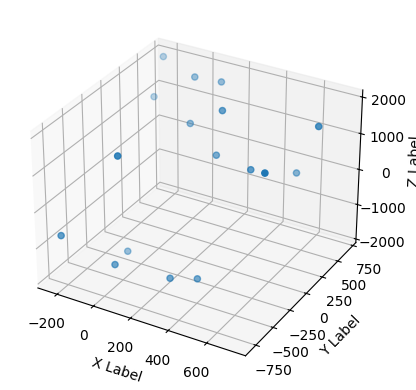

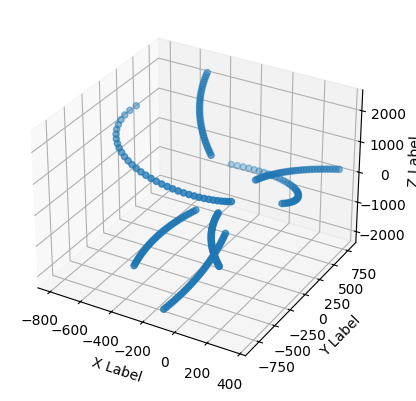

In [174]:
draw_event(df0)
draw_event(df1)

### Подсчет f1_score

In [166]:
from sklearn.metrics import f1_score

f1 = f1_score(y_test_right, prediction)

f1

1.0